# *Monod* model selection: fit to liver cell types

In the current notebook, we run the *Monod* inference pipeline on two pre-clustered human liver datasets, disaggregated into pericentral, periportal, and interzonal hepatocytes, using a common set of 3,000 genes and four models (bursty, extrinsic, delayed-splicing, and delayed-efflux).

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
print('heck')

heck


In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [3]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [4]:
dataset_meta = ['brain_5k_v3','brain_nuc_5k_v3']

# cluster_names = ['CentralHep','PortalHep','InterHep']
dataset_names = dataset_meta 
raw_data_locations = dataset_meta
# dataset_names = ['liver_c72_'+x+'_'+y for x in dataset_meta for y in cluster_names]

transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

unspliced_layer = 'unspliced'
spliced_layer = 'spliced'
ambiguous_layer = 'ambiguous'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer,ambiguous_layer),gene_attr,cell_attr]


loom_filepaths = ['/home/ggorin/dlist_count_data/loom_kb/'+x+'.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)

In [5]:
loom_filepaths

['/home/ggorin/dlist_count_data/loom_kb/brain_5k_v3.loom',
 '/home/ggorin/dlist_count_data/loom_kb/brain_nuc_5k_v3.loom']

In [6]:
n_datasets = len(loom_filepaths)

## Filtering

### Import metadata

In [7]:
# import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy

In [8]:
print('hi')

hi


/home/ggorin/dlist_count_data/loom_kb/brain_5k_v3.loom
Dataset brain_5k_v3. 
	5483 barcodes in loom, 4887 pass filter.
/home/ggorin/dlist_count_data/loom_kb/brain_nuc_5k_v3.loom
Dataset brain_nuc_5k_v3. 
	5899 barcodes in loom, 5224 pass filter.


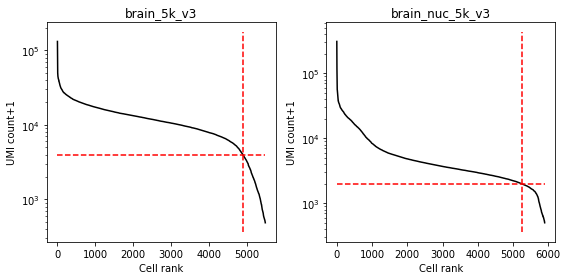

In [30]:
cf = []
thr_lb = [4e3, 2e3]
thr_ub = [5e4, 5e4]
S_arr = []
U_arr = []


fig1,ax1 = plt.subplots(1,2,figsize=(8,4))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[k]
    dataset_name = dataset_meta[k]
    print(filename)
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        total_RNA = ds.layers[spliced_layer][:] + ds.layers[unspliced_layer][:] + ds.layers[ambiguous_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = total_RNA.shape[1]
        monod.preprocess.knee_plot(total_RNA,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = (total_RNA.sum(0)>thr_lb[k]) & (total_RNA.sum(0)<thr_ub[k])
        ax1[k].set_title(dataset_meta[k])        
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter.')

        S_arr.append(S)
        U_arr.append(U)
        cf.append(cf_)
fig1.tight_layout()

In [31]:
[x.sum() for x in cf]

[4887, 5224]

## Sc/sn comparison

In [9]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=False):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))

/tmp/ipykernel_2892499/1943922227.py:5: RuntimeWarning: invalid value encountered in divide
  stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)


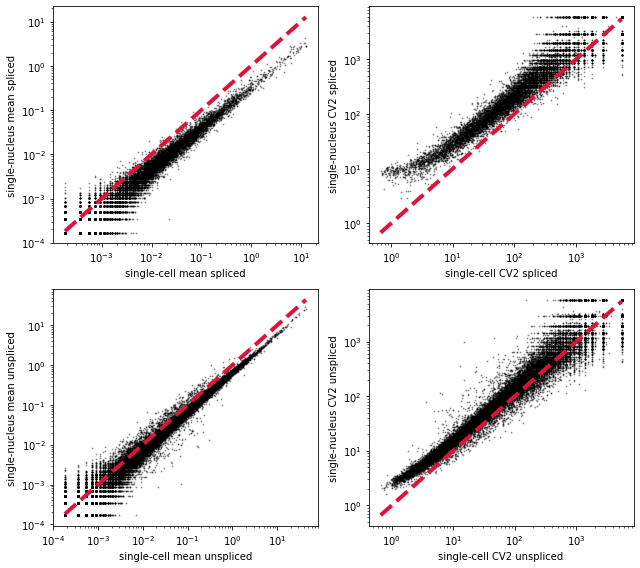

In [33]:
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(S_arr[0],S_arr[1],'mean',ax1[0][0],'spliced')
plot_stat(S_arr[0],S_arr[1],'CV2',ax1[0][1],'spliced')
plot_stat(U_arr[0],U_arr[1],'mean',ax1[1][0],'unspliced')
plot_stat(U_arr[0],U_arr[1],'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()


/tmp/ipykernel_2892499/680583236.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)


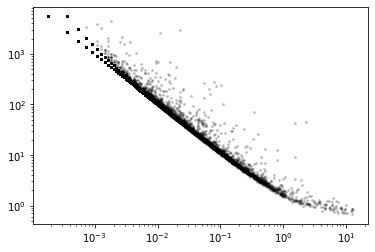

In [34]:
plt.scatter(S_arr[0].mean(1),S_arr[0].var(1)/(S_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

/tmp/ipykernel_2892499/2533449854.py:1: RuntimeWarning: invalid value encountered in divide
  plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)


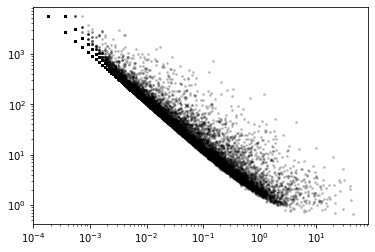

In [35]:
plt.scatter(U_arr[0].mean(1),U_arr[0].var(1)/(U_arr[0].mean(1)**2),3,'k',alpha=0.2)
plt.xscale('log')
plt.yscale('log')

## Preprocessing

Identify the genes to fit.

Construct a batch by finding 3,000 genes which have at least moderate expression across all datasets. Visualize the set of genes (purple) that meet the expression filtering criteria.

In [10]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [11]:
transcriptome_filepath

'../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1 created.
INFO:root:Dataset: brain_5k_v3
INFO:root:4887 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31676 were unique.
INFO:root:908 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3 created.
INFO:root:Dataset: brain_nuc_5k_v3
INFO:root:5224 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31676 were unique.
INFO:root:633 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3 created.
INFO:root:Total of 500 genes selected.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/diagnostic_figures created.


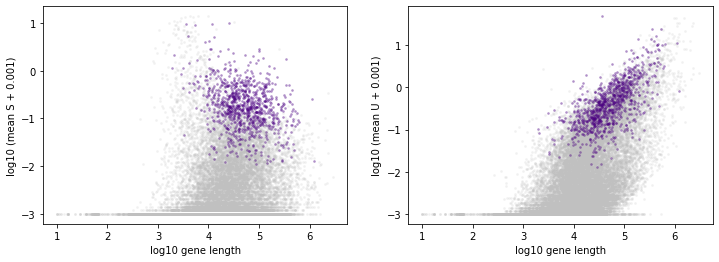

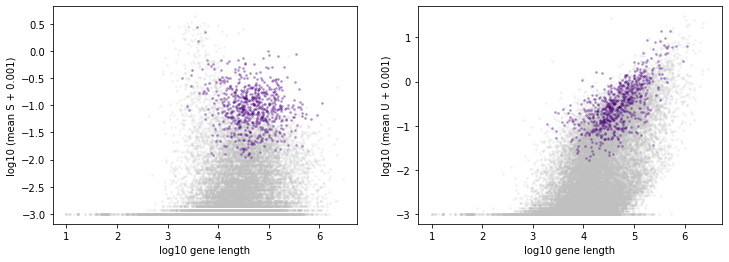

In [38]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='brain_nuc_1k',batch_id=1,\
                                             n_genes=500,exp_filter_threshold=None,cf=cf)

## Inference

In [12]:
dir_string='./fits/gg_230219_025_brain_nuc_1k_1'


In [13]:
dataset_strings=['./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3',
 './fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3']


Define parameter bounds, then iterate over datasets and perform the fits.

In [41]:
phys_lb = [-1.0, -1.8, -1.8,-1.5,-1.5]
phys_ub = [4.2, 2.5, 3.5,0,0]
# samp_lb = [1,1]
# samp_ub = [1, 1]
# gridsize = [1,1]
samp_lb = [-8, -2.5]
samp_ub = [-5, 0]
gridsize = [7,8]

gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1}

In [ ]:
result_strings = []
for i in range(n_datasets):
#     fitmodel = monod.cme_toolbox.CMEModel('Bursty','None','Unequal')
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson','Unequal')
    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = gradient_params)
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)
    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8 created.
INFO:root:Global inference parameters stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: brain_5k_v3
INFO:root:32285 features observed, 32005 match genome annotations. 31676 were unique.
INFO:root:Gene list extracted from ./fits/gg_230219_025_brain_nuc_1k_1/genes.csv.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/diagnostic_figures created.
INFO:root:Search data stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/raw.sd.
INFO:root:Starting parallelized grid scan.


 55%|████████████████████████████████████████████████████████████████████                                                       | 31/56 [2:42:30<57:52, 138.89s/it]

## Post-processing

In [14]:
# result_strings
result_strings=['./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res',
 './fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res']
# 

In [15]:
# dir_string = './fits/gg_230212_025_brain_nuc_1k_1'
dir_string 

'./fits/gg_230219_025_brain_nuc_1k_1'

In [16]:
# dataset_strings=['./fits/gg_230212_025_brain_nuc_1k_1/brain_5k_v3',
#  './fits/gg_230212_025_brain_nuc_1k_1/brain_nuc_5k_v3']
dataset_strings

['./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3',
 './fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3']

INFO:root:Grid scan results loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/raw.sd.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/analysis_figures/kldiv.png.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/analysis_figures/length_dependence.png.
INFO:root:No rejection statistics have been computed.
INFO:root:Figure stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/analysis_figures/parameter_marginals.png.
INFO:root:Directory ./fits/gg_230219_025_brain_nuc_1k_1/analysis_figures already exists.
INFO:root:Grid scan results loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res.
INF

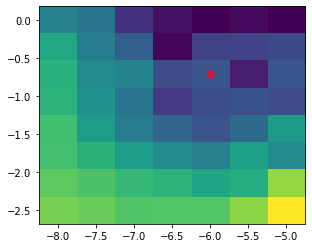

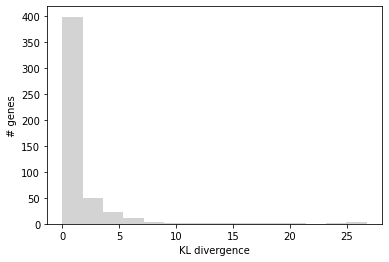

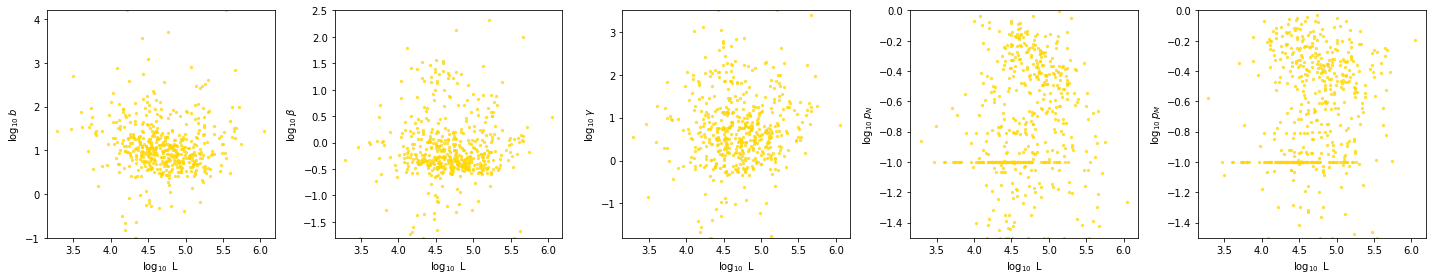

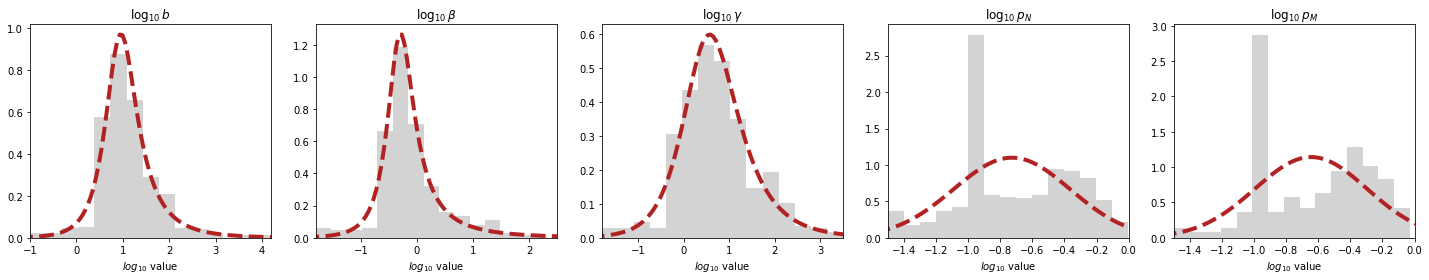

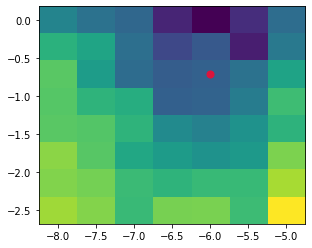

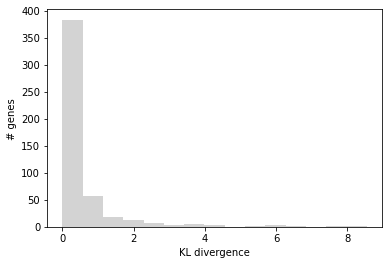

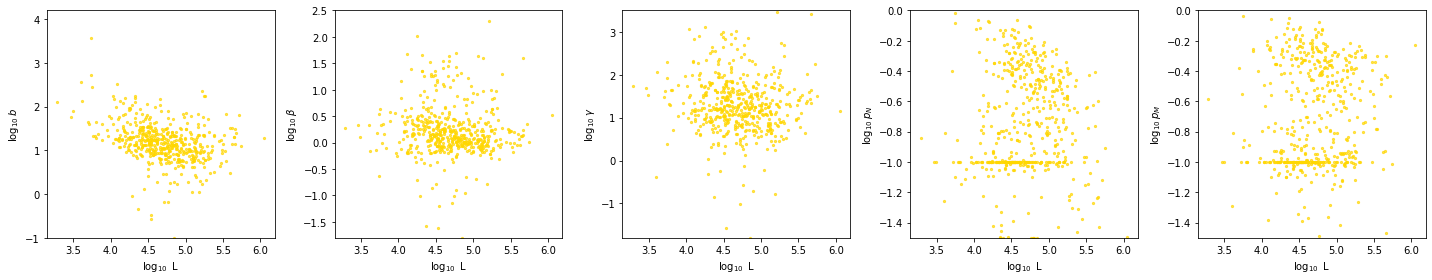

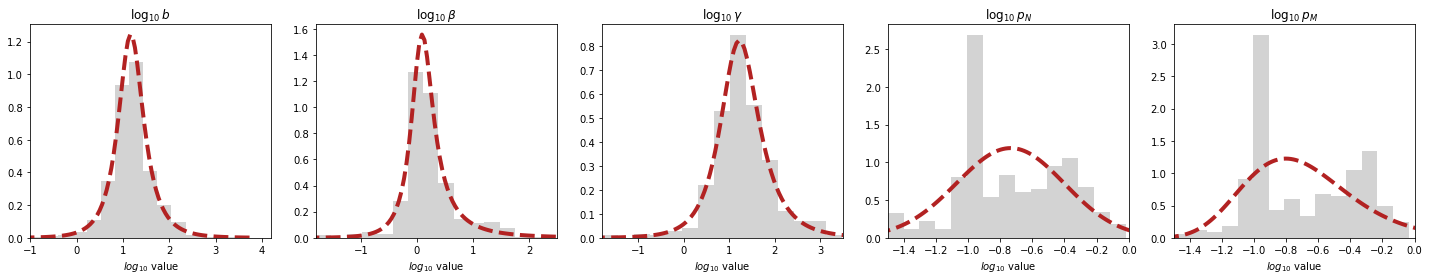

In [81]:
sr_arr = []
sd_arr = []
for i in range(n_datasets):
#     sr = monod.analysis.load_search_results(result_strings[i])
#     sr.model = monod.cme_toolbox.CMEModel('Bursty','None','Unequal')
#     sd = monod.analysis.load_search_data(dataset_strings[i]+'/raw.sd')
#     sr.find_sampling_optimum()

# #     sr.plot_gene_distributions(sd,marg='nascent')

# #     _=sr.chisquare_testing(sd)

#     sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
#     sr.plot_param_marg()
    
#     monod.analysis.make_batch_analysis_dir([sr],dir_string)
#     sr.update_on_disk()

    sr = monod.analysis.load_search_results(result_strings[i])
    sd = monod.analysis.load_search_data(dir_string+'/'+dataset_names[i]+'/raw.sd')
    fig1,ax1 = plt.subplots(1,1)
    sr.find_sampling_optimum()
    sr.set_sampling_optimum(ind)
    sr.plot_landscape(ax1)

    fig1,ax1 = plt.subplots(1,1)
    sr.plot_KL(ax1)

#     sr.plot_gene_distributions(sd,marg='joint')

#     _=sr.chisquare_testing(sd,threshold=0.01)
#     sr.resample_opt_viz()
#     sr.resample_opt_mc_viz()
#     sr.chisq_best_param_correction(sd,Ntries=4,viz=False,threshold=0.01) 

#     sr.compute_sigma(sd,num_cores=60)
    sr.plot_param_L_dep(plot_errorbars=False,plot_fit=True)
    sr.plot_param_marg()
    
    monod.analysis.make_batch_analysis_dir([sr],dir_string)
    sr.update_on_disk()
    
    sr_arr.append(sr)
    sd_arr.append(sd)


In [37]:
sr.sp.sampl_vals

[(-8.0, -2.5),
 (-8.0, -2.375),
 (-8.0, -2.25),
 (-8.0, -2.125),
 (-8.0, -2.0),
 (-8.0, -1.875),
 (-8.0, -1.75),
 (-8.0, -1.625),
 (-8.0, -1.5),
 (-8.0, -1.375),
 (-8.0, -1.25),
 (-8.0, -1.125),
 (-8.0, -1.0),
 (-8.0, -0.875),
 (-8.0, -0.75),
 (-8.0, -0.625),
 (-8.0, -0.5),
 (-8.0, -0.375),
 (-8.0, -0.25),
 (-8.0, -0.125),
 (-8.0, 0.0),
 (-7.842105263157895, -2.5),
 (-7.842105263157895, -2.375),
 (-7.842105263157895, -2.25),
 (-7.842105263157895, -2.125),
 (-7.842105263157895, -2.0),
 (-7.842105263157895, -1.875),
 (-7.842105263157895, -1.75),
 (-7.842105263157895, -1.625),
 (-7.842105263157895, -1.5),
 (-7.842105263157895, -1.375),
 (-7.842105263157895, -1.25),
 (-7.842105263157895, -1.125),
 (-7.842105263157895, -1.0),
 (-7.842105263157895, -0.875),
 (-7.842105263157895, -0.75),
 (-7.842105263157895, -0.625),
 (-7.842105263157895, -0.5),
 (-7.842105263157895, -0.375),
 (-7.842105263157895, -0.25),
 (-7.842105263157895, -0.125),
 (-7.842105263157895, 0.0),
 (-7.684210526315789, -2.5),

In [53]:
ind = np.argmin(((np.array(sr.sp.sampl_vals) - np.asarray([-6,-0.8]) )**2).sum(1))

In [54]:
sr.set_sampling_optimum(ind)

(-6.0, -0.7142857142857142)

INFO:root:No rejection statistics have been computed.


/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:4511: RuntimeWarning: invalid value encountered in multiply
  return fac1 * sc.k1e(a * sq) * np.exp(b*x - a*sq) / sq


INFO:root:Figure stored to ./fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/Bursty_Poisson_7x8/analysis_figures/parameter_marginals.png.


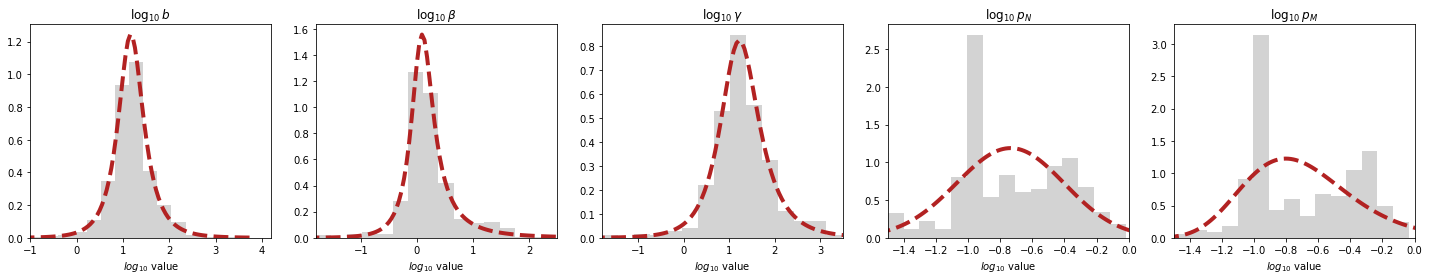

In [55]:
sr.plot_param_marg()

In [56]:
sr.phys_optimum.shape

(500, 5)

In [57]:
sd.layers[1].mean(1).shape

(500,)

In [58]:
10**np.asarray(sr.regressor_optimum)

array([[0.077472  , 0.19306977],
       [0.05757   , 0.19306977],
       [0.125398  , 0.19306977],
       [0.104061  , 0.19306977],
       [0.166307  , 0.19306977],
       [0.18467   , 0.19306977],
       [0.174233  , 0.19306977],
       [0.014456  , 0.19306977],
       [0.034074  , 0.19306977],
       [0.092836  , 0.19306977],
       [0.032439  , 0.19306977],
       [0.032126  , 0.19306977],
       [0.147904  , 0.19306977],
       [0.075558  , 0.19306977],
       [0.074765  , 0.19306977],
       [0.003987  , 0.19306977],
       [0.034851  , 0.19306977],
       [0.086488  , 0.19306977],
       [0.300533  , 0.19306977],
       [0.035415  , 0.19306977],
       [0.025788  , 0.19306977],
       [0.03383   , 0.19306977],
       [0.075115  , 0.19306977],
       [0.03932   , 0.19306977],
       [0.057098  , 0.19306977],
       [0.031903  , 0.19306977],
       [0.133211  , 0.19306977],
       [0.135461  , 0.19306977],
       [0.115321  , 0.19306977],
       [0.069832  , 0.19306977],
       [0.

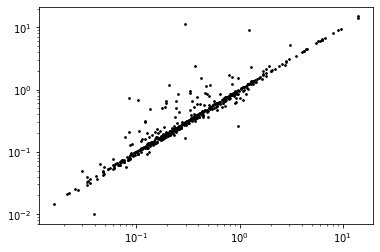

In [59]:
m = sd.layers[0].mean(1)
b = 10**sr.phys_optimum[:,0]
beta = 10**sr.phys_optimum[:,1]
L = 10**np.asarray(sr.regressor_optimum[:,0])
res = 1-10**np.asarray(sr.phys_optimum[:,3])
mapp = b/beta*L*res
plt.scatter(m,mapp,3,'k')

plt.xscale('log')
plt.yscale('log')

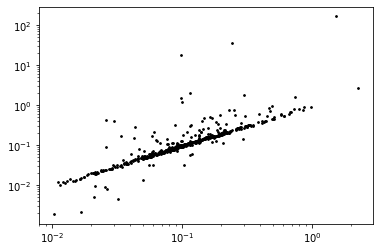

In [80]:
m = sd.layers[1].mean(1)
b = 10**sr.phys_optimum[:,0]
gamma = 10**sr.phys_optimum[:,2]
L = 10**np.asarray(sr.regressor_optimum[:,1])
res = 1-10**np.asarray(sr.phys_optimum[:,4])
mapp = b/gamma*L*res
plt.scatter(m,mapp,3,'k')

plt.xscale('log')
plt.yscale('log')

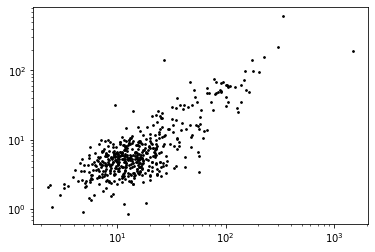

In [61]:
# plt.scatter(sd.layers[1].mean(1),sd.layers[2].mean(1),3,'k')
plt.scatter(sd.layers[1].var(1)/sd.layers[1].mean(1)**2,sd.layers[2].var(1)/sd.layers[2].mean(1)**2,3,'k')
plt.xscale('log')
plt.yscale('log')

In [62]:
sd.layers[0].mean(1).shape

(500,)

## Analysis

In [ ]:
# dir_string = './fits/gg_221209_025_brain_nuc_1'
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]

In [24]:
result_strings

['./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res',
 './fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res']

In [25]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]
sd_arr = [monod.analysis.load_search_data(dir_string+'/'+x+'/raw.sd') for x in dataset_names]

INFO:root:Grid scan results loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/Bursty_Poisson_7x8/grid_scan_results.res.
INFO:root:Search data loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_5k_v3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230219_025_brain_nuc_1k_1/brain_nuc_5k_v3/raw.sd.


Offset: -0.46
Offset: -0.20


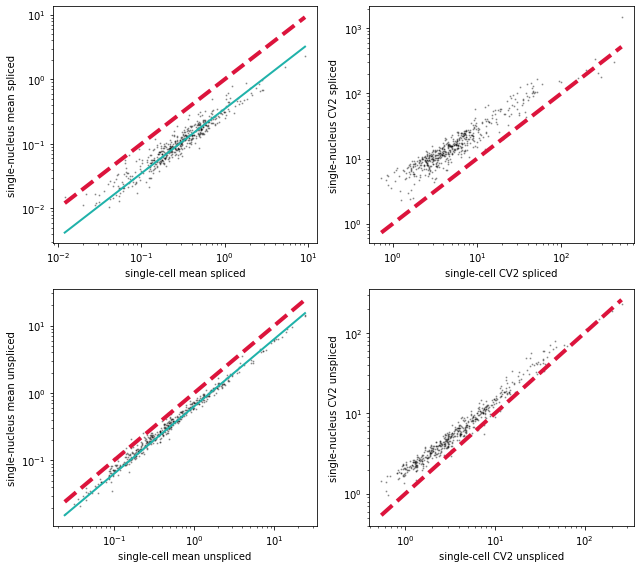

In [19]:
# for k in range(3):
fig1,ax1 = plt.subplots(2,2,figsize=(9,8))

plot_stat(sd_arr[0].layers[1],
          sd_arr[1].layers[1],
          'mean',ax1[0][0],'spliced',True)
plot_stat(sd_arr[0].layers[1],
          sd_arr[1].layers[1],
          'CV2',ax1[0][1],'spliced')
plot_stat(sd_arr[0].layers[0],
          sd_arr[1].layers[0],
          'mean',ax1[1][0],'unspliced',True)
plot_stat(sd_arr[0].layers[0],
          sd_arr[1].layers[0],
          'CV2',ax1[1][1],'unspliced')
fig1.tight_layout()

In [20]:
# arbitrary_v2_params = np.asarray([-7,-2])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# print(sr_arr[0].sp.sampl_vals[arbitrary_v2_ind])

In [21]:
# samp_lb

In [22]:
# samp_ub

sc: -6.00, -1.07
sn: -6.00, -1.07
0.48746926303983146
0.7209201051510692
0.6413194940408962


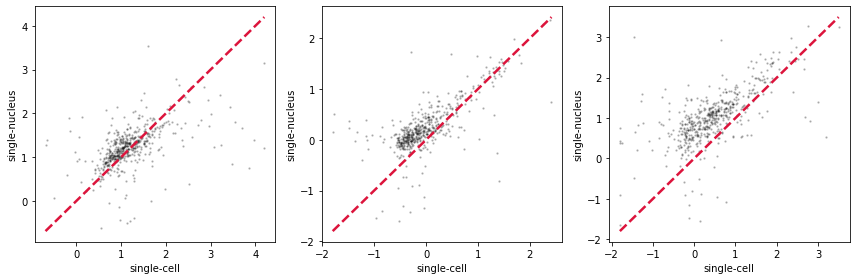

In [29]:
# for k in range(3):
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
k=0
arbitrary_v3_params = np.asarray([-6,-1.1])
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)

# total_divg = ((sr_arr[0].param_estimates[:,~sr_arr[1].rejected_genes,:2] 
#                         - sr_arr[1].phys_optimum[~sr_arr[1].rejected_genes,:2])**2).sum((1,2))
# arbitrary_v2_ind = np.argmin(total_divg)
# arbitrary_v3_params = np.asarray(sr_arr[1].samp_optimum)+0.1
# # arbitrary_v3_params += 0.1
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[0].set_sampling_optimum(arbitrary_v3_ind)
# sr_arr[0].set_sampling_optimum(arbitrary_v2_ind)

print('sc: {:.2f}, {:.2f}'.format(*sr_arr[0].samp_optimum))

print('sn: {:.2f}, {:.2f}'.format(*sr_arr[1].samp_optimum))
for j in range(3):
    x = sr_arr[0].phys_optimum[:,j]
    y = sr_arr[1].phys_optimum[:,j]
    print(np.corrcoef(x,y)[0,1])
#     y = sr_arr[1].phys_optimum[~sr_arr[k].rejected_genes,j]
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('single-cell')
    ax1[j].set_ylabel('single-nucleus')
fig1.tight_layout()

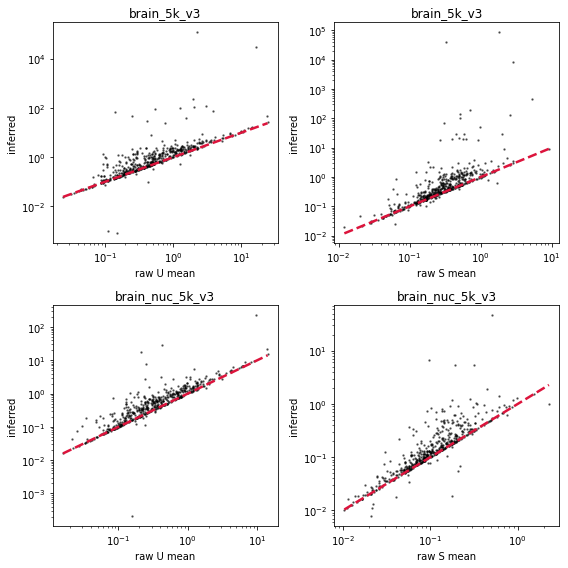

In [30]:
# arbitrary_v3_params = np.asarray([-6.5,0])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)
fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

k=0
for j in range(2):
    physopts = 10**sr_arr[k+j].phys_optimum
    sampopts = 10**sr_arr[k+j].regressor_optimum
    
    x = sd_arr[k+j].layers[0].mean(1)
    y = sampopts[:,0]*physopts[:,0]/physopts[:,1]
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('raw U mean')
    ax1[j,0].set_ylabel('inferred')
    
    x = sd_arr[k+j].layers[1].mean(1)
    y = sampopts[:,1]*physopts[:,0]/physopts[:,2]
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('raw S mean')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

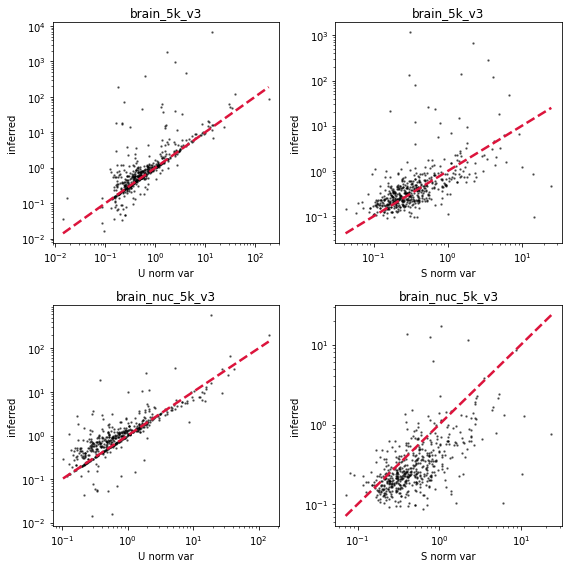

In [31]:
k=0

# arbitrary_v2_params = np.asarray([-8,-2.5])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

# arbitrary_v3_params = np.asarray([-6.2,-1.5])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

for j in range(2):
    
    physopts = 10**sr_arr[k+j].phys_optimum
    sampopts = 10**sr_arr[k+j].regressor_optimum
    
    x = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    y = sampopts[:,0] * (1 + physopts[:,0])
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('U norm var')
    ax1[j,0].set_ylabel('inferred')
    
    x = (sd_arr[k+j].layers[1].var(1))/(sd_arr[k+j].layers[1].mean(1))-1
    y = sampopts[:,1] * (1 + physopts[:,0] * physopts[:,1]/(physopts[:,1] + physopts[:,2]))
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('S norm var')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

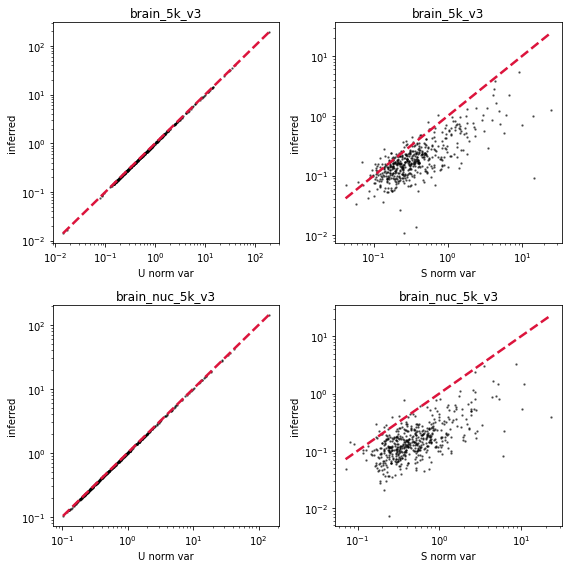

In [71]:
k=0

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))

for j in range(2):
    
    physopts = 10**sr_arr[k+j].phys_optimum
#     sampopts = 10**sr_arr[k+j].regressor_optimum
    b = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    beta = b/sd_arr[k+j].layers[0].mean(1)
    gamma = b/sd_arr[k+j].layers[1].mean(1)
    
    x = (sd_arr[k+j].layers[0].var(1))/(sd_arr[k+j].layers[0].mean(1))-1
    y = b
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,0].set_xscale('log')
    ax1[j,0].set_yscale('log')
    ax1[j,0].set_title(dataset_names[k+j])
    ax1[j,0].set_xlabel('U norm var')
    ax1[j,0].set_ylabel('inferred')
    
    x = (sd_arr[k+j].layers[1].var(1))/(sd_arr[k+j].layers[1].mean(1))-1
    y = b*beta/(beta+gamma)
    ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j,1].set_xscale('log')
    ax1[j,1].set_yscale('log')
    ax1[j,1].set_title(dataset_names[k+j])
    ax1[j,1].set_xlabel('S norm var')
    ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

In [72]:
sd_arr[0]

In [73]:
sr_arr[k].samp_optimum

(-6.0, -1.0714285714285714)

In [74]:
sr_arr[0].regressor_optimum

array([[-1.11085523, -1.07142857],
       [-1.23980377, -1.07142857],
       [-0.90170939, -1.07142857],
       [-0.982712  , -1.07142857],
       [-0.77908947, -1.07142857],
       [-0.73360365, -1.07142857],
       [-0.75886959, -1.07142857],
       [-1.83995186, -1.07142857],
       [-1.46757688, -1.07142857],
       [-1.03228358, -1.07142857],
       [-1.48893254, -1.07142857],
       [-1.49314334, -1.07142857],
       [-0.83002008, -1.07142857],
       [-1.12171955, -1.07142857],
       [-1.12630166, -1.07142857],
       [-2.39935376, -1.07142857],
       [-1.45778476, -1.07142857],
       [-1.06304415, -1.07142857],
       [-0.52210783, -1.07142857],
       [-1.45081275, -1.07142857],
       [-1.58858234, -1.07142857],
       [-1.470698  , -1.07142857],
       [-1.12427333, -1.07142857],
       [-1.40538649, -1.07142857],
       [-1.2433791 , -1.07142857],
       [-1.49616848, -1.07142857],
       [-0.87545991, -1.07142857],
       [-0.86818572, -1.07142857],
       [-0.9380916 ,

In [75]:
dataset_names

['brain_5k_v3', 'brain_nuc_5k_v3']

In [76]:
# k

In [77]:
from matplotlib.colors import ListedColormap
c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


In [78]:
k=0

arbitrary_v3_params = np.asarray([-6,-1.2])
arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
sr_arr[k+1].set_sampling_optimum(arbitrary_v3_ind)

total_divg = ((sr_arr[k].param_estimates[:,~sr_arr[k+1].rejected_genes,:2] 
                        - sr_arr[k+1].phys_optimum[~sr_arr[k+1].rejected_genes,:2])**2).sum((1,2))

arbitrary_v2_ind = np.argmin(total_divg)
sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,1,figsize=(5,5))
dx = (np.asarray(sr_arr[0].sp.samp_ub) - np.asarray(sr_arr[0].sp.samp_lb)) / (
    np.asarray(sr_arr[0].sp.gridsize) - 1
)
dx[dx < 1e-10] = 0.1
extent = [
    sr_arr[0].sp.samp_lb[0] - dx[0] / 2,
    sr_arr[0].sp.samp_ub[0] + dx[0] / 2,
    sr_arr[0].sp.samp_lb[1] - dx[1] / 2,
    sr_arr[0].sp.samp_ub[1] + dx[1] / 2,
]
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg, sr_arr[0].sp.gridsize).T), extent=extent
)

q = np.quantile(total_divg,0.1)
lnd = ax1.imshow(
    np.flipud(np.reshape(total_divg>q, sr.sp.gridsize).T), extent=extent,
    cmap = cmap_highlight_landscape,alpha=0.5
)

ax1.scatter(sr_arr[k+1].samp_optimum[0], sr_arr[k+1].samp_optimum[1], c="crimson", s=50)

ax1.scatter(sr_arr[k].samp_optimum[0], sr_arr[k].samp_optimum[1], c="cyan", s=100)

AttributeError: 'SearchResults' object has no attribute 'rejected_genes'

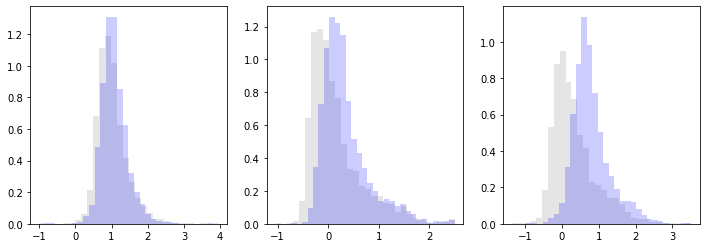

In [44]:

# for k in range(3):


#     arbitrary_v3_params = np.asarray([-6,-1])
#     arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
#     sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

#     arbitrary_v2_params = np.asarray([-6.7,-3])
#     arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
#     sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*1+['b']*1
for j in range(3):
    for k,sr in enumerate(sr_arr):
        ax1[j].hist(sr.phys_optimum[:,j],30,alpha=0.2,color=colors[k],density=True)

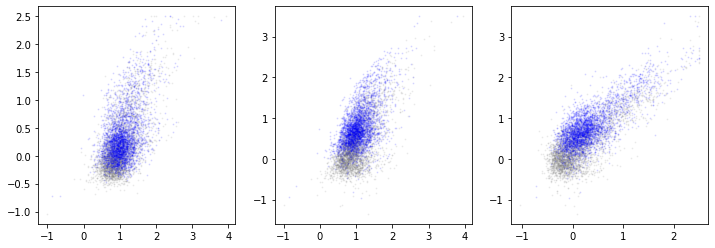

In [45]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
colors = ['gray']*1+['b']*1
for j,pair in enumerate([[0,1],[0,2],[1,2]]):
    for k,sr in enumerate(sr_arr):
        ax1[j].scatter(sr.phys_optimum[:,pair[0]],sr.phys_optimum[:,pair[1]],1,alpha=0.1,c=colors[k])

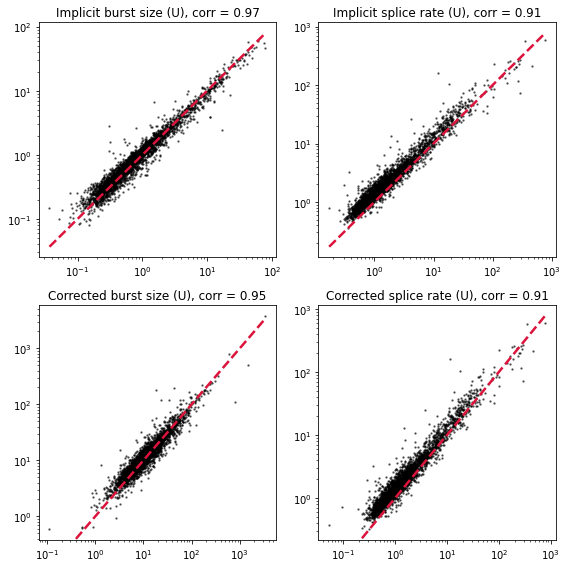

In [48]:
# k=0

# arbitrary_v2_params = np.asarray([-8,-2.5])
# arbitrary_v2_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v2_params)**2).sum(1))
# sr_arr[k].set_sampling_optimum(arbitrary_v2_ind)

# arbitrary_v3_params = np.asarray([-6.2,-1.5])
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
# sr_arr[k+3].set_sampling_optimum(arbitrary_v3_ind)

fig1,ax1 = plt.subplots(2,2,figsize=(8,8))
k=0
for j in range(1):
    
#     physopts = 10**sr_arr[k+j].phys_optimum
#     sampopts = 10**sr_arr[k+j].regressor_optimum
    
    x = (sd_arr[j].layers[0].var(1))/(sd_arr[j].layers[0].mean(1))-1 
    y = (sd_arr[j+len(cluster_names)].layers[0].var(1))/(sd_arr[j+len(cluster_names)].layers[0].mean(1))-1
    ax1[j,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[0,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[0,0].set_xscale('log')
    ax1[0,0].set_yscale('log')
    ax1[0,0].set_title('Implicit burst size (U), corr = {:.2f}'.format(np.corrcoef(x,y)[0,1]))
    
    x = x/sd_arr[j].layers[0].mean(1)
    y = y/sd_arr[j+len(cluster_names)].layers[0].mean(1)
    ax1[0,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[0,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[0,1].set_xscale('log')
    ax1[0,1].set_yscale('log')
    ax1[0,1].set_title('Implicit splice rate (U), corr = {:.2f}'.format(np.corrcoef(x,y)[0,1]))
    
    x = ((sd_arr[j].layers[0].var(1))/(sd_arr[j].layers[0].mean(1))-1)/(10**sr_arr[j].regressor_optimum[:,0])-1
    y = ((sd_arr[j+len(cluster_names)].layers[0].var(1))/(sd_arr[j+len(cluster_names)].layers[0].mean(1))-1)\
        /(10**sr_arr[j+len(cluster_names)].regressor_optimum[:,0])-1
    ax1[1,0].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[1,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[1,0].set_xscale('log')
    ax1[1,0].set_yscale('log')
    ax1[1,0].set_title('Corrected burst size (U), corr = {:.2f}'.format(np.corrcoef(x,y)[0,1]))
    
    x = x/sd_arr[j].layers[0].mean(1)*(10**sr_arr[j].regressor_optimum[:,0])
    y = y/sd_arr[j+len(cluster_names)].layers[0].mean(1)*(10**sr_arr[j+len(cluster_names)].regressor_optimum[:,0])
    ax1[1,1].scatter(x,y,2,'k',alpha=0.5)
    xl = np.linspace(min(x),max(x))
    ax1[1,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[1,1].set_xscale('log')
    ax1[1,1].set_yscale('log')
    ax1[1,1].set_title('Corrected splice rate (U), corr = {:.2f}'.format(np.corrcoef(x,y)[0,1]))

#     ax1[j,0].set_xlabel('U norm var')
#     ax1[j,0].set_ylabel('inferred')
    
#     x = (sd_arr[k+j].layers[1].var(1))/(sd_arr[k+j].layers[1].mean(1))-1
#     y = sampopts[:,1] * (1 + physopts[:,0] * physopts[:,1]/(physopts[:,1] + physopts[:,2]))
#     ax1[j,1].scatter(x,y,2,'k',alpha=0.5)
#     xl = np.linspace(min(x),max(x))
#     ax1[j,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
#     ax1[j,1].set_xscale('log')
#     ax1[j,1].set_yscale('log')
#     ax1[j,1].set_title(dataset_names[k+j])
#     ax1[j,1].set_xlabel('S norm var')
#     ax1[j,1].set_ylabel('inferred')
fig1.tight_layout()

In [47]:
cluster_names = ['all']

In [139]:
sd=sd_arr[0]

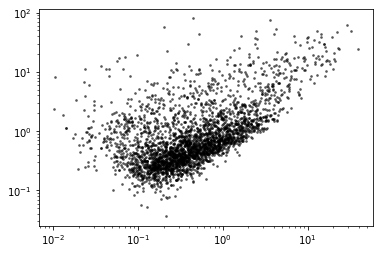

In [140]:
means = sd.layers[0].mean(1)
Fanos = sd.layers[0].var(1)/means-1
plt.scatter(means,Fanos,3,'k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')

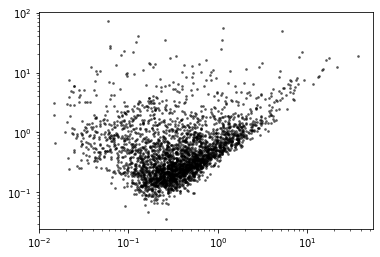

In [141]:
means = sd.layers[1].mean(1)
Fanos = sd.layers[1].var(1)/means-1
plt.scatter(means,Fanos,3,'k',alpha=0.5)
plt.xscale('log')
plt.yscale('log')

Let's go back and see if I allowed serious issues to slip in BR.

In [299]:
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]


In [345]:
batch = 3
k=3
sr = monod.analysis.load_search_results('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sd = monod.analysis.load_search_data('../../GP_2021_3/notebooks/fits/'+batch_dirs[batch]+'/'+dataset_v3_list[batch][k]+'/raw.sd')


physopts  = 10**sr.phys_optimum

INFO:root:Grid scan results loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_H12/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Search data loaded from ../../GP_2021_3/notebooks/fits/gg_221118_025_allen_1/allen_H12/raw.sd.


In [346]:
sampopts = 10**sr.regressor_optimum

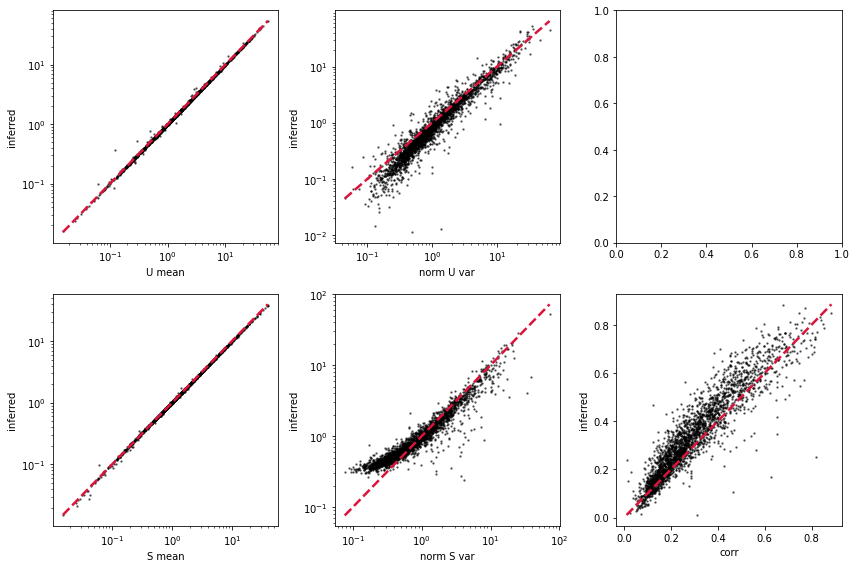

In [351]:

fig1,ax1 = plt.subplots(2,3,figsize=(12,8))


x = sd.layers[0].mean(1)
y = sampopts[:,0] * physopts[:,0]/physopts[:,1]
ax1[0,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('U mean')
ax1[0,0].set_ylabel('inferred')

x = sd.layers[1].mean(1)
y = sampopts[:,1] * physopts[:,0]/physopts[:,2]
ax1[1,0].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,0].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,0].set_xscale('log')
ax1[1,0].set_yscale('log')
ax1[1,0].set_xlabel('S mean')
ax1[1,0].set_ylabel('inferred')


x = sd.layers[0].var(1)/sd.layers[0].mean(1) - 1
y = sampopts[:,0] * (1+physopts[:,0])
ax1[0,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[0,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[0,1].set_xscale('log')
ax1[0,1].set_yscale('log')
ax1[0,1].set_xlabel('norm U var')
ax1[0,1].set_ylabel('inferred')

F = physopts[:,1]/(physopts[:,1] + physopts[:,2])

x = sd.layers[1].var(1)/sd.layers[1].mean(1) - 1
y = sampopts[:,1] * (1+physopts[:,0] * F)
ax1[1,1].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,1].plot(xl,xl,'--',color='crimson',linewidth=2.5)
ax1[1,1].set_xscale('log')
ax1[1,1].set_yscale('log')
ax1[1,1].set_xlabel('norm S var')
ax1[1,1].set_ylabel('inferred')

x = np.asarray([np.corrcoef(x)[0][1] for x in zip(sd.layers[0],sd.layers[1])])
b = physopts[:,0] 
y = np.sqrt(b**2 * F*(1-F) * sampopts[:,0] * sampopts[:,1] /((1+sampopts[:,0]*(1+b))*(1+sampopts[:,1]*(1+b*F))))
ax1[1,2].scatter(x,y,2,'k',alpha=0.5)
xl = np.linspace(min(x),max(x))
ax1[1,2].plot(xl,xl,'--',color='crimson',linewidth=2.5)
# ax1[1,2].set_xscale('log')
# ax1[1,2].set_yscale('log')
ax1[1,2].set_xlabel('corr')
ax1[1,2].set_ylabel('inferred')
fig1.tight_layout()

Meh. Not so much.